# **Identifying Key Entities in Recipe Data**


**Business Objective**:
The goal of this assignment is to train a Named Entity Recognition (NER) model using Conditional Random Fields (CRF) to extract key entities from recipe data. The model will classify words into predefined categories such as ingredients, quantities and units, enabling the creation of a structured database of recipes and ingredients that can be used to power advanced features in recipe management systems, dietary tracking apps, or e-commerce platforms.

### **Data Description**
The given data is in JSON format, representing a **structured recipe ingredient list** with **Named Entity Recognition (NER) labels**. Below is a breakdown of the data fields:

```json
[
    {
        "input": "6 Karela Bitter Gourd Pavakkai Salt 1 Onion 3 tablespoon Gram flour besan 2 teaspoons Turmeric powder Haldi Red Chilli Cumin seeds Jeera Coriander Powder Dhania Amchur Dry Mango Sunflower Oil",
        "pos": "quantity ingredient ingredient ingredient ingredient ingredient quantity ingredient quantity unit ingredient ingredient ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient"
    },
    {
      "input": "2-1/2 cups rice cooked 3 tomatoes teaspoons BC Belle Bhat powder 1 teaspoon chickpea lentils 1/2 cumin seeds white urad dal mustard green chilli dry red 2 cashew or peanuts 1-1/2 tablespoon oil asafoetida",
      "pos": "quantity unit ingredient ingredient quantity ingredient unit ingredient ingredient ingredient ingredient quantity unit ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient quantity unit ingredient ingredient"
    }
]


| **Key**  | **Description**  |
|----------|-----------------|
| `input`  | Contains a raw ingredient list from a recipe. |
| `pos`    | Represents the corresponding part-of-speech (POS) tags or NER labels, identifying quantities, ingredients, and units. |


## **1** Import libraries

#### **1.1** Installation of sklearn-crfsuite

sklearn-crfsuite is a Python wrapper for CRFsuite, a fast and efficient implementation of Conditional Random Fields (CRFs). It is designed to integrate seamlessly with scikit-learn for structured prediction tasks such as Named Entity Recognition (NER), Part-of-Speech (POS) tagging, and chunking.

In [29]:
# installation of sklearn_crfsuite
!pip install sklearn_crfsuite==0.5.0

#### **1.2** Import necessary libraries

In [10]:
# Import warnings
import warnings
warnings.filterwarnings('ignore')

In [11]:
!pip install spacy

In [12]:
# Import necessary libraries
import json  # For handling JSON data
import pandas as pd  # For data manipulation and analysis
import re  # For regular expressions (useful for text preprocessing)
import matplotlib.pyplot as plt  # For visualisation
import seaborn as sns  # For advanced data visualisation
import sklearn_crfsuite  # CRF (Conditional Random Fields) implementation for sequence modeling
import numpy as np  # For numerical computations
# Saving and loading machine learning models
import joblib
import random
import spacy
from IPython.display import display, Markdown # For displaying well-formatted output
!pip install sklearn-crfsuite
from fractions import Fraction  # For handling fractional values in numerical data
# Importing tools for feature engineering and model training
from collections import Counter  # For counting occurrences of elements in a list
from sklearn.model_selection import train_test_split  # For splitting dataset into train and test sets
from sklearn_crfsuite import metrics  # For evaluating CRF models
from sklearn_crfsuite.metrics import flat_classification_report
from sklearn.utils.class_weight import compute_class_weight
from collections import Counter
from sklearn.metrics import confusion_matrix

In [13]:
# Ensure pandas displays full content
pd.set_option('display.max_colwidth', None)
pd.set_option('display.expand_frame_repr', False)

## **2** Data Ingestion and Preparation <font color = red>[25 marks]</font> <br>

#### **2.1** *Read Recipe Data from Dataframe and prepare the data for analysis* <font color = red>[12 marks]</font> <br>
Read the data from JSON file, print first five rows and describe the dataframe
#Data file path
data_file_path = '\ingredient_and_quantity.json'

In [16]:
#Data file path
import os

data_file_path = os.path.join(os.path.expanduser("~"), 'ingredient_and_quantity.json')

##### **2.1.1** **Define a *load_json_dataframe* function** <font color = red>[7 marks]</font> <br>

Define a function that takes path of the ingredient_and_quantity.json file and reads it, convert it into dataframe - df and return it.

In [18]:
# define a function to load json file to a dataframe
# define a function to load json file to a dataframe

def load_json_to_dataframe(file_path):
    """
    Loads a JSON file into a pandas DataFrame.

    Parameters:
        file_path (str): Path to the JSON file.

    Returns:
        pd.DataFrame or str: DataFrame if successful, otherwise a specific error message.
    """
    try:
        if not os.path.exists(file_path):
            raise FileNotFoundError(f"File not found: '{file_path}'")

        with open(file_path, 'r', encoding='utf-8') as f:
            try:
                data = json.load(f)
            except json.JSONDecodeError as jde:
                return f"JSONDecodeError: Invalid JSON format. {str(jde)}"

        # Ensure data is in a suitable format for DataFrame (list or dict)
        if not isinstance(data, (list, dict)):
            return "TypeError: JSON must be a list or dict to convert to DataFrame."

        df = pd.DataFrame(data)

        return df

    except FileNotFoundError as fnf:
        return f"FileNotFoundError: {str(fnf)}"
    except PermissionError as pe:
        return f"PermissionError: Cannot read file due to permission issue. {str(pe)}"
    except ValueError as ve:
        return f"ValueError: Issue with data structure. {str(ve)}"
    except Exception as e:
        return f"Unhandled Exception: {type(e).__name__}: {str(e)}"


##### **2.1.2** **Execute the *load_json_dataframe* function** <font color = red>[2 marks]</font> <br>

In [20]:
# read the json file by giving the file path and create a dataframe
# read the json file by giving the file path and create a dataframe
data_df = load_json_to_dataframe(data_file_path)

##### **2.1.3** **Describe the dataframe** <font color = red>[3 marks]</font> <br>

Print first five rows of dataframe along with dimensions. Display the information of dataframe

In [22]:
# display first five rows of the dataframe - df
data_df.head()

,input,pos
0,6 Karela Bitter Gourd Pavakkai Salt 1 Onion 3 tablespoon Gram flour besan 2 teaspoons Turmeric powder Haldi Red Chilli Cumin seeds Jeera Coriander Powder Dhania Amchur Dry Mango Sunflower Oil,quantity ingredient ingredient ingredient ingredient ingredient quantity ingredient quantity unit ingredient ingredient ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient
1,2-1/2 cups rice cooked 3 tomatoes teaspoons BC Belle Bhat powder 1 teaspoon chickpea lentils 1/2 cumin seeds white urad dal mustard green chilli dry red 2 cashew or peanuts 1-1/2 tablespoon oil asafoetida,quantity unit ingredient ingredient quantity ingredient unit ingredient ingredient ingredient ingredient quantity unit ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient quantity unit ingredient ingredient
2,1-1/2 cups Rice Vermicelli Noodles Thin 1 Onion sliced 1/2 cup Carrots Gajjar chopped 1/3 Green peas Matar 2 Chillies 1/4 teaspoon Asafoetida hing Mustard seeds White Urad Dal Split Ghee sprig Curry leaves Salt Lemon juice,quantity unit ingredient ingredient ingredient ingredient quantity ingredient ingredient quantity unit ingredient ingredient ingredient quantity ingredient ingredient ingredient quantity ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient unit ingredient ingredient ingredient ingredient ingredient
3,500 grams Chicken 2 Onion chopped 1 Tomato 4 Green Chillies slit inch Ginger finely 6 cloves Garlic 1/2 teaspoon Turmeric powder Haldi Garam masala tablespoon Sesame Gingelly Oil 1/4 Methi Seeds Fenugreek Coriander Dhania Dry Red Fennel seeds Saunf cups Sorrel Leaves Gongura picked and,quantity unit ingredient quantity ingredient ingredient quantity ingredient quantity ingredient ingredient ingredient unit ingredient ingredient quantity unit ingredient quantity unit ingredient ingredient ingredient ingredient ingredient unit ingredient ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient unit ingredient ingredient ingredient ingredient ingredient
4,1 tablespoon chana dal white urad 2 red chillies coriander seeds 3 inches ginger onion tomato Teaspoon mustard asafoetida sprig curry,quantity unit ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient ingredient quantity unit ingredient ingredient ingredient unit ingredient ingredient unit ingredient


In [23]:
# print the dimensions of dataframe - df
data_df.shape

(285, 2)

In [24]:
# print the information of the dataframe
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 285 entries, 0 to 284
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   input   285 non-null    object
 1   pos     285 non-null    object
dtypes: object(2)
memory usage: 4.6+ KB


#### **2.2** *Recipe Data Manipulation* <font color = red>[13 marks]</font> <br>
Create derived metrics in dataframe and provide insights of the dataframe

##### **2.2.1** **Create input_tokens and pos_tokens columns by splitting the input and pos from the dataframe** <font color = red>[3 marks]</font> <br>
Split the input and pos into input_tokens and pos_tokens in the dataframe and display it in the dataframe

In [27]:
# split the input and pos into input_tokens and pos_tokens in the dataframe

# Tokenize input
data_df['input_tokens'] = data_df['input'].str.split()

# Tokenize POS
data_df['pos_tokens'] = data_df['pos'].str.split()

In [28]:
# display first five rows of the dataframe - df
data_df.head()

,input,pos,input_tokens,pos_tokens
0,6 Karela Bitter Gourd Pavakkai Salt 1 Onion 3 tablespoon Gram flour besan 2 teaspoons Turmeric powder Haldi Red Chilli Cumin seeds Jeera Coriander Powder Dhania Amchur Dry Mango Sunflower Oil,quantity ingredient ingredient ingredient ingredient ingredient quantity ingredient quantity unit ingredient ingredient ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient,"[6, Karela, Bitter, Gourd, Pavakkai, Salt, 1, Onion, 3, tablespoon, Gram, flour, besan, 2, teaspoons, Turmeric, powder, Haldi, Red, Chilli, Cumin, seeds, Jeera, Coriander, Powder, Dhania, Amchur, Dry, Mango, Sunflower, Oil]","[quantity, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, quantity, unit, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient]"
1,2-1/2 cups rice cooked 3 tomatoes teaspoons BC Belle Bhat powder 1 teaspoon chickpea lentils 1/2 cumin seeds white urad dal mustard green chilli dry red 2 cashew or peanuts 1-1/2 tablespoon oil asafoetida,quantity unit ingredient ingredient quantity ingredient unit ingredient ingredient ingredient ingredient quantity unit ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient quantity unit ingredient ingredient,"[2-1/2, cups, rice, cooked, 3, tomatoes, teaspoons, BC, Belle, Bhat, powder, 1, teaspoon, chickpea, lentils, 1/2, cumin, seeds, white, urad, dal, mustard, green, chilli, dry, red, 2, cashew, or, peanuts, 1-1/2, tablespoon, oil, asafoetida]","[quantity, unit, ingredient, ingredient, quantity, ingredient, unit, ingredient, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient]"
2,1-1/2 cups Rice Vermicelli Noodles Thin 1 Onion sliced 1/2 cup Carrots Gajjar chopped 1/3 Green peas Matar 2 Chillies 1/4 teaspoon Asafoetida hing Mustard seeds White Urad Dal Split Ghee sprig Curry leaves Salt Lemon juice,quantity unit ingredient ingredient ingredient ingredient quantity ingredient ingredient quantity unit ingredient ingredient ingredient quantity ingredient ingredient ingredient quantity ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient unit ingredient ingredient ingredient ingredient ingredient,"[1-1/2, cups, Rice, Vermicelli, Noodles, Thin, 1, Onion, sliced, 1/2, cup, Carrots, Gajjar, chopped, 1/3, Green, peas, Matar, 2, Chillies, 1/4, teaspoon, Asafoetida, hing, Mustard, seeds, White, Urad, Dal, Split, Ghee, sprig, Curry, leaves, Salt, Lemon, juice]","[quantity, unit, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, quantity, unit, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, quantity, ingredient, quantity, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, unit, ingredient, ingredient, ingredient, ingredient, ingredient]"
3,500 grams Chicken 2 Onion chopped 1 Tomato 4 Green Chillies slit inch Ginger finely 6 cloves Garlic 1/2 teaspoon Turmeric powder Haldi Garam masala tablespoon Sesame Gingelly Oil 1/4 Methi Seeds Fenugreek Coriander Dhania Dry Red Fennel seeds Saunf cups Sorrel Leaves Gongura picked and,quantity unit ingredient quantity ingredient ingredient quantity ingredient quantity ingredient ingredient ingredient unit ingredient ingredient qua

##### **2.2.2** **Provide the length for input_tokens and pos_tokens and validate their length** <font color = red>[2 marks]</font> <br>

Create input_length and pos_length columns in the dataframe and validate both the lengths. Check for the rows that are unequal in input and pos length


In [30]:
# create input_length and pos_length columns for the input_tokens and pos-tokens
data_df['input_length'] = data_df['input_tokens'].apply(lambda x:len(x))
data_df['pos_length'] = data_df['pos_tokens'].apply(lambda x: len(x))

In [31]:
data_df.head(3)

,input,pos,input_tokens,pos_tokens,input_length,pos_length
0,6 Karela Bitter Gourd Pavakkai Salt 1 Onion 3 tablespoon Gram flour besan 2 teaspoons Turmeric powder Haldi Red Chilli Cumin seeds Jeera Coriander Powder Dhania Amchur Dry Mango Sunflower Oil,quantity ingredient ingredient ingredient ingredient ingredient quantity ingredient quantity unit ingredient ingredient ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient,"[6, Karela, Bitter, Gourd, Pavakkai, Salt, 1, Onion, 3, tablespoon, Gram, flour, besan, 2, teaspoons, Turmeric, powder, Haldi, Red, Chilli, Cumin, seeds, Jeera, Coriander, Powder, Dhania, Amchur, Dry, Mango, Sunflower, Oil]","[quantity, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, quantity, unit, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient]",31,31
1,2-1/2 cups rice cooked 3 tomatoes teaspoons BC Belle Bhat powder 1 teaspoon chickpea lentils 1/2 cumin seeds white urad dal mustard green chilli dry red 2 cashew or peanuts 1-1/2 tablespoon oil asafoetida,quantity unit ingredient ingredient quantity ingredient unit ingredient ingredient ingredient ingredient quantity unit ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient quantity unit ingredient ingredient,"[2-1/2, cups, rice, cooked, 3, tomatoes, teaspoons, BC, Belle, Bhat, powder, 1, teaspoon, chickpea, lentils, 1/2, cumin, seeds, white, urad, dal, mustard, green, chilli, dry, red, 2, cashew, or, peanuts, 1-1/2, tablespoon, oil, asafoetida]","[quantity, unit, ingredient, ingredient, quantity, ingredient, unit, ingredient, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient]",34,34
2,1-1/2 cups Rice Vermicelli Noodles Thin 1 Onion sliced 1/2 cup Carrots Gajjar chopped 1/3 Green peas Matar 2 Chillies 1/4 teaspoon Asafoetida hing Mustard seeds White Urad Dal Split Ghee sprig Curry leaves Salt Lemon juice,quantity unit ingredient ingredient ingredient ingredient quantity ingredient ingredient quantity unit ingredient ingredient ingredient quantity ingredient ingredient ingredient quantity ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient unit ingredient ingredient ingredient ingredient ingredient,"[1-1/2, cups, Rice, Vermicelli, Noodles, Thin, 1, Onion, sliced, 1/2, cup, Carrots, Gajjar, chopped, 1/3, Green, peas, Matar, 2, Chillies, 1/4, teaspoon, Asafoetida, hing, Mustard, seeds, White, Urad, Dal, Split, Ghee, sprig, Curry, leaves, Salt, Lemon, juice]","[quantity, unit, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, quantity, unit, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, quantity, ingredient, quantity, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, unit, ingredient, ingredient, ingredient, ingredient, ingredient]",37,37


In [32]:
# check for the equality of input_length and pos_length in the dataframe
data_df['length_equal'] = data_df['input_length'] == data_df['pos_length']

unequal_row_df = data_df[data_df['length_equal'] == False]

#Print total could of rows with unequal length
print(f"Total rows with unequal lenght: {len(unequal_row_df)}")

#Index of unequal rows
index_unequal = list(data_df[data_df['length_equal'] == False].index)
print("Index for rows with unequal length:")
print(index_unequal)

Total rows with unequal lenght: 5
Index for rows with unequal length:
[17, 27, 79, 164, 207]


##### **2.2.3** **Define a unique_labels function and validate the labels in pos_tokens** <font color = red>[2 marks]</font> <br>

Define a unique_labels function which checks for all the unique pos labels in the recipe & execute it.


In [34]:
# Define a unique_labels function to checks for all the unique pos labels in the recipe & print it
def unique_labels(df):
    unique_pos_labels = set([label for sublist in df['pos_tokens'] for label in sublist])
    print("Unique POS Labels:", unique_pos_labels)

unique_labels(data_df)

Unique POS Labels: {'unit', 'ingredient', 'quantity'}


##### **2.2.3** **Provide the insights seen in the recipe data after validation** <font color = red>[1 marks]</font> <br>

Provide the indexes that requires cleaning and formatting in the dataframe

<font color = red>[write your answer]</font> <br>


##### **2.2.4** **Drop the rows that have invalid data provided in previous cell** <font color = red> [2 marks]</font> <br>

In [38]:
# drop the irrelevant recipe data
data_df.drop(index_unequal, inplace=True)

In [39]:
#Shape of dataframe after removing unequal data rows
data_df.shape

(280, 7)

##### **2.2.5** **Update the input_length & pos_length in dataframe**<font color = red> [2 marks]</font> <br>

In [41]:
# update the input and pos length in input_length and pos_length
# As input_length and input_tokens columns were already created and filled, it's not required to perform same task again post removal or unequal data rows, but
# as it's a 2 marks task, redoing the the same process again
data_df['input_length']=data_df['input_tokens'].apply(lambda x:len(x))
data_df['pos_length']=data_df['pos_tokens'].apply(lambda x:len(x))

##### **2.2.6** **Validate the input_length and pos_length by checking unequal rows** <font color = red> [1 marks]</font> <br>

In [43]:
# validate the input length and pos length as input_length and pos_length
if (data_df['input_length'] == data_df['pos_length']).all():
    print("All rows have the same length in 'input_length' and 'pos_length")
else:
    print("Rows have unequal length in 'input_length' and 'pos_length'")

All rows have the same length in 'input_length' and 'pos_length


## **3** Train Validation Split (70 train - 30 val) <font color = red>[6 marks]</font> <br>

#### **3.1** *Perform train and validation split ratio* <font color = red>[6 marks]</font> <br>
Split the dataset with the help of input_tokens and pos_tokens and make a ratio of 70:30 split for training and validation datasets.

###### **3.1.1** **Split the dataset into train_df and val_df into 70:30 ratio** <font color = red> [1 marks]</font> <br>

In [47]:
# split the dataset into training and validation sets
train_df,val_df=train_test_split(data_df,test_size=0.3,random_state=42)

###### **3.1.2** **Print the first five rows of train_df and val_df** <font color = red> [1 marks]</font> <br>

In [49]:
# print the first five rows of train_df
train_df.head()

,input,pos,input_tokens,pos_tokens,input_length,pos_length,length_equal
179,250 grams Okra Oil 1 Onion finely chopped Tomato Grated teaspoon Ginger 2 Garlic Finely 1/2 Cumin seeds 1/4 Teaspoon asafoetida cup cottage cheese pinched coriander powder mango red chilli turmeric,quantity unit ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient unit ingredient quantity ingredient ingredient quantity ingredient ingredient quantity unit ingredient unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient,"[250, grams, Okra, Oil, 1, Onion, finely, chopped, Tomato, Grated, teaspoon, Ginger, 2, Garlic, Finely, 1/2, Cumin, seeds, 1/4, Teaspoon, asafoetida, cup, cottage, cheese, pinched, coriander, powder, mango, red, chilli, turmeric]","[quantity, unit, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, ingredient, ingredient, unit, ingredient, quantity, ingredient, ingredient, quantity, ingredient, ingredient, quantity, unit, ingredient, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient]",31,31,True
57,200 grams Paneer Homemade Cottage Cheese 2 Potato Aloo Bay leaf tej patta Dry Red Chilli 1 tablespoon Panch Phoran Masala roasted and powdered Tomato big sized teaspoon Turmeric powder Haldi Cumin seeds Jeera Ginger grated Salt 1/2 Sugar Sunflower Oil,quantity unit ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient,"[200, grams, Paneer, Homemade, Cottage, Cheese, 2, Potato, Aloo, Bay, leaf, tej, patta, Dry, Red, Chilli, 1, tablespoon, Panch, Phoran, Masala, roasted, and, powdered, Tomato, big, sized, teaspoon, Turmeric, powder, Haldi, Cumin, seeds, Jeera, Ginger, grated, Salt, 1/2, Sugar, Sunflower, Oil]","[quantity, unit, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, ingredient]",41,41,True
112,500 grams Cabbage Patta Gobi Muttaikose 1 teaspoon Mustard seeds 1-1/2 White Urad Dal Split sprig Curry leaves Green Chilli 1/4 cup Fresh coconut Salt,quantity unit ingredient ingredient ingredient ingredient quantity unit ingredient ingredient quantity ingredient ingredient ingredient ingredient unit ingredient ingredient ingredient ingredient quantity unit ingredient ingredient ingredient,"[500, grams, Cabbage, Patta, Gobi, Muttaikose, 1, teaspoon, Mustard, seeds, 1-1/2, White, Urad, Dal, Split, sprig, Curry, leaves, Green, Chilli, 1/4, cup, Fresh, coconut, Salt]","[quantity, unit, ingredient, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, ingredient, unit, ingredient, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient, ingredient]",25,25,True
218,500 grams Fresh Figs 1/4 cup Lemon juice 1 teaspoon zest 2 Red Chilli flakes 1/2 Honey Brown Sugar (Demerara Sugar),quantity unit ingredient ingredient quantity unit ingredient ingredient quantity unit ingredient quantity ingredient ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient,"[500, grams, Fresh, Figs, 1/4, cup, Lemon, juice, 1, teaspoon, zest, 2, Red, Chilli, flakes, 1/2, Honey, Brown, Sugar, (Demerara, Sugar)]","[quantity, unit, ingredient, ingredient, quantity, unit,

In [50]:
# print the first five rows of the val_df
val_df.head()

,input,pos,input_tokens,pos_tokens,input_length,pos_length,length_equal
35,1 cup Ada 2 liter Milk 3/4 Sugar tablespoon Ghee 1/2 teaspoon Cardamom Powder Elaichi,quantity unit ingredient quantity unit ingredient quantity ingredient unit ingredient quantity unit ingredient ingredient ingredient,"[1, cup, Ada, 2, liter, Milk, 3/4, Sugar, tablespoon, Ghee, 1/2, teaspoon, Cardamom, Powder, Elaichi]","[quantity, unit, ingredient, quantity, unit, ingredient, quantity, ingredient, unit, ingredient, quantity, unit, ingredient, ingredient, ingredient]",15,15,True
111,1 Carrot Gajjar chopped 7 Potatoes Aloo 2 cups Cauliflower gobi cut to small florets Onion tablespoon Ginger Garlic Paste Salt teaspoons Sunflower Oil 1/2 cup Fresh coconut grated teaspoon Whole Black Peppercorns Green Chillies Fennel seeds Saunf Poppy 6 Cashew nuts inch Cinnamon Stick Dalchini Star anise 3 Cloves Laung Cardamom Elaichi Pods/Seeds Cumin Jeera,quantity ingredient ingredient ingredient quantity ingredient ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient unit ingredient ingredient ingredient ingredient unit ingredient ingredient quantity unit ingredient ingredient ingredient unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient quantity ingredient ingredient unit ingredient ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient ingredient,"[1, Carrot, Gajjar, chopped, 7, Potatoes, Aloo, 2, cups, Cauliflower, gobi, cut, to, small, florets, Onion, tablespoon, Ginger, Garlic, Paste, Salt, teaspoons, Sunflower, Oil, 1/2, cup, Fresh, coconut, grated, teaspoon, Whole, Black, Peppercorns, Green, Chillies, Fennel, seeds, Saunf, Poppy, 6, Cashew, nuts, inch, Cinnamon, Stick, Dalchini, Star, anise, 3, Cloves, Laung, Cardamom, Elaichi, Pods/Seeds, Cumin, Jeera]","[quantity, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, quantity, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, unit, ingredient, ingredient, ingredient, ingredient, unit, ingredient, ingredient, quantity, unit, ingredient, ingredient, ingredient, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, unit, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient]",56,56,True
245,1 tablespoon Sunflower Oil 3 Potato Aloo Ginger paste Green Chilli chopped 1-1/12 tablespoons Sesame seeds Til teaspoon Red powder Cumin Jeera Coriander Powder Dhania 1/2 Garam masala 2 Sweet Chutney Date Tamarind Leaves few,quantity unit ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient ingredient quantity unit ingredient ingredient ingredient unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient quantity ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient,"[1, tablespoon, Sunflower, Oil, 3, Potato, Aloo, Ginger, paste, Green, Chilli, chopped, 1-1/12, tablespoons, Sesame, seeds, Til, teaspoon, Red, powder, Cumin, Jeera, Coriander, Powder, Dhania, 1/2, Garam, masala, 2, Sweet, Chutney, Date, Tamarind, Leaves, few]","[quantity, unit, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient, ingredient, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient]",35,35,True
264,1 cup green peas gram flour 1/2 cheese tsp ginger 2 chillies turmeric powder cumin teaspoon salt oil,quantity unit ingredient ingredient ingredient ingredient quantity ingredient unit ingr

###### **3.1.3** **Extract the dataset into train_df and val_df into X_train, X_val, y_train and y_val and display their length** <font color = red> [2 marks]</font> <br>

Extract X_train, X_val, y_train and y_val by extracting the list of input_tokens and pos_tokens from train_df and val_df and also display their length

In [52]:
# extract the training and validation sets by taking input_tokens and pos_tokens
X_train=train_df['input_tokens']
X_val=val_df['input_tokens']
y_train=train_df['pos_tokens']
y_val=val_df['pos_tokens']

In [53]:
# validate the shape of training and validation samples
print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of X_val:", X_val.shape)
print("Shape of y_val:", y_val.shape)

Shape of X_train: (196,)
Shape of y_train: (196,)
Shape of X_val: (84,)
Shape of y_val: (84,)


###### **3.1.4** **Display the number of unique labels present in y_train** <font color = red> [2 marks]</font> <br>

In [55]:
# Display the number of unique labels present in y_train
list(y_train.explode().unique())

['quantity', 'unit', 'ingredient']

## **4** Exploratory Recipe Data Analysis on Training Dataset <font color = red>[16 marks]</font> <br>

#### **4.1** *Flatten the lists for input_tokens & pos_tokens* <font color = red>[2 marks]</font> <br>

Define a function **flatten_list** for flattening the structure for input_tokens and pos_tokens. The input parameter passed to this function is a nested list.

Initialise the dataset_name with a value ***'Training'***




In [58]:
# flatten the list for nested_list (input_tokens, pos_tokens)
from itertools import chain
def flatten_list(nested_list):
  return list(chain.from_iterable(nested_list))

In [59]:
# initialise the dataset_name
dataset_name = 'Training'

#### **4.2** *Extract and validate the tokens after using the flattening technique* <font color = red>[2 marks]</font> <br>

Define a function named ***extract_and_validate_tokens*** with parameters dataframe and dataset_name (Training/Validation), validate the length of input_tokens and pos_tokens from dataframe and display first 10 records for both the input_tokens and pos_tokens. Execute this function




In [61]:
# define a extract_and_validate_tokens with parameters (df, dataset_name)
# call the flatten_list and apply it on input_tokens and pos_tokens
# validate their length and display first 10 records having input and pos tokens
def extract_and_validate_tokens(df, dataset_name):
    # Flatten the input_tokens and pos_tokens using the flatten_list function
    flat_input_tokens = flatten_list(df['input_tokens'])
    flat_pos_tokens = flatten_list(df['pos_tokens'])

    # Validate the lengths of the flattened tokens
    print(f"{dataset_name} - Length of input_tokens:", len(flat_input_tokens))
    print(f"{dataset_name} - Length of pos_tokens:", len(flat_pos_tokens))

    #Validate input Pos token length
    if (len(flat_input_tokens) == len(flat_pos_tokens)):
        print(f"{dataset_name} - Length of input_tokens and pos_tokens are equal")
    else:
        print(f"{dataset_name} - Length of input_tokens and pos_tokens are not equal")

    # Display first 10 records of input_tokens and pos_tokens
    print(f"{dataset_name} - First 10 input_tokens:", flat_input_tokens[:10])
    print(f"{dataset_name} - First 10 pos_tokens:", flat_pos_tokens[:10])
    print("\n")

    return flat_input_tokens, flat_pos_tokens

In [62]:
# extract the tokens and its pos tags
#Call the extract_and_validate_tokens function for training dataset
print("Validation for Training set:\n")
train_flat_input_tokens, train_flat_pos_tokens = extract_and_validate_tokens(train_df, dataset_name)

#Call the extract_and_validate_tokens function for Validation dataset
print("Validation for Validation set:\n")
val_flat_input_tokens, val_flat_pos_tokens = extract_and_validate_tokens(val_df, 'Validation')

Validation for Training set:

Training - Length of input_tokens: 7114
Training - Length of pos_tokens: 7114
Training - Length of input_tokens and pos_tokens are equal
Training - First 10 input_tokens: ['250', 'grams', 'Okra', 'Oil', '1', 'Onion', 'finely', 'chopped', 'Tomato', 'Grated']
Training - First 10 pos_tokens: ['quantity', 'unit', 'ingredient', 'ingredient', 'quantity', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient']


Validation for Validation set:

Validation - Length of input_tokens: 2876
Validation - Length of pos_tokens: 2876
Validation - Length of input_tokens and pos_tokens are equal
Validation - First 10 input_tokens: ['1', 'cup', 'Ada', '2', 'liter', 'Milk', '3/4', 'Sugar', 'tablespoon', 'Ghee']
Validation - First 10 pos_tokens: ['quantity', 'unit', 'ingredient', 'quantity', 'unit', 'ingredient', 'quantity', 'ingredient', 'unit', 'ingredient']




#### **4.3** *Categorise tokens into labels (unit, ingredient, quantity)* <font color = red>[2 marks]</font> <br>

Define a function ***categorize_tokens*** to categorise tokens into ingredients, units and quantities by using extracted tokens in the previous code and return a list of ingredients, units and quantities. Execute this function to get the list.



In [64]:
# define a categorize_tokens function and provide the tokens and pos_tags as parameters and create ingredient, unit and quantity list and return it
# validate the list that it comprised of these labels, if not return empty arrays
def categorize_tokens(tokens, pos_tags):
    # Initialize empty lists for ingredients, units, and quantities
    ingredients = []
    units = []
    quantities = []

    # Iterate through the tokens and categorize them based on the POS tag
    for token, pos in zip(tokens, pos_tags):
        if pos == 'ingredient':
            ingredients.append(token)
        elif pos == 'unit':
            units.append(token)
        elif pos == 'quantity':
            quantities.append(token)

    # Return the categorized lists
    return ingredients, units, quantities



In [65]:
#  call the function to categorise the labels into respective list
ingredient_list, unit_list, quantity_list= categorize_tokens(train_flat_input_tokens, train_flat_pos_tokens)

#### **4.4** *Top 10 Most Frequent Items* <font color = red>[3 marks]</font> <br>

Define a function ***get_top_frequent_items*** to display top 10 most frequent items

Here, item_list is used as a general parameter where you will call this function for ingredient and unit list

Execute this function separately for top 10 most units and ingredients



In [67]:
# define a function get_top_frequent_items to get the top frequent items by using item_list, pos label and dataset_name(Training/Validation) and return top items
def get_top_frequent_items(item_list):
  counter=Counter(item_list)
  topitems=counter.most_common(10)
  return topitems


In [68]:
# get the top ingredients which are frequently seen in the recipe
topingredients=get_top_frequent_items(ingredient_list)
topingredients

[('powder', 129),
 ('Salt', 102),
 ('seeds', 89),
 ('Green', 85),
 ('chopped', 84),
 ('Oil', 83),
 ('Red', 81),
 ('Chilli', 77),
 ('Coriander', 71),
 ('Sunflower', 65)]

In [69]:
# get the top units which are frequently seen in the recipe
topunits = get_top_frequent_items(unit_list)
topunits

[('teaspoon', 162),
 ('cup', 136),
 ('tablespoon', 99),
 ('grams', 63),
 ('tablespoons', 61),
 ('inch', 52),
 ('cups', 50),
 ('sprig', 41),
 ('cloves', 39),
 ('teaspoons', 39)]

#### **4.5** *Plot Top 10 most frequent items* <font color = red>[2 marks]</font> <br>




Define a function ***plot_top_items*** to plot a bar graph on top 10 most frequent items for units and ingredients

Here, item_list is used as a general parameter where you will call this function for ingredient and unit list

In [72]:
# define plot top items with parameters - top_item list, label to suggest whether its ingredient or unit, dataset_name
def plot_top_items(items, xlabel, title):
    labels, counts = zip(*items)

    items_series = pd.Series(counts, index=labels)

    plt.figure(figsize=(12, 8))
    items_series.plot(kind='bar', color='green')
    plt.xlabel(xlabel, fontsize=14)
    plt.ylabel('Frequency', fontsize=14)
    plt.title(f'Top {xlabel} in {title} Data', fontsize=16)
    plt.xticks(rotation=45, ha='right', fontsize=12)
    plt.yticks(fontsize=12)
    plt.tight_layout()
    plt.show()

#### **4.6** *Perform EDA analysis* <font color = red>[5 marks]</font> <br>

Plot the bar plots for ingredients and units and provide the insights for training dataset

---



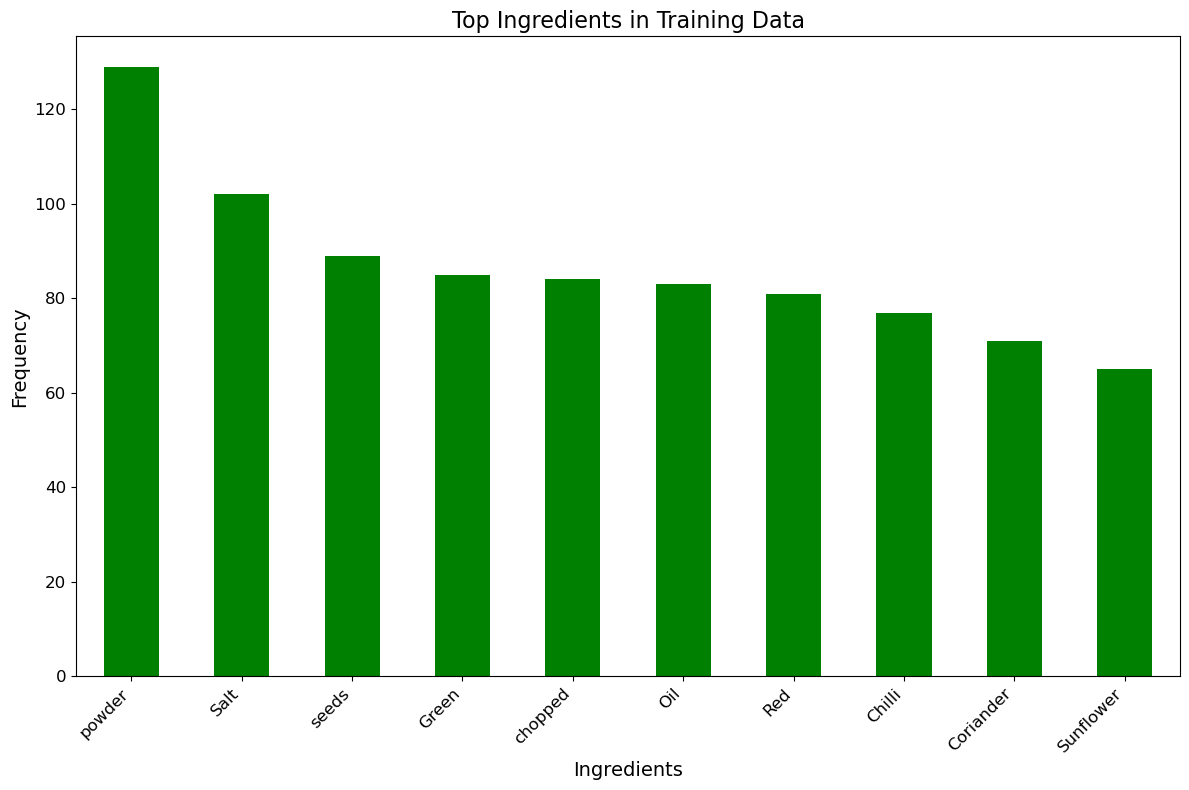

In [74]:
# plot the top frequent ingredients in training data
plot_top_items(topingredients, 'Ingredients', dataset_name)

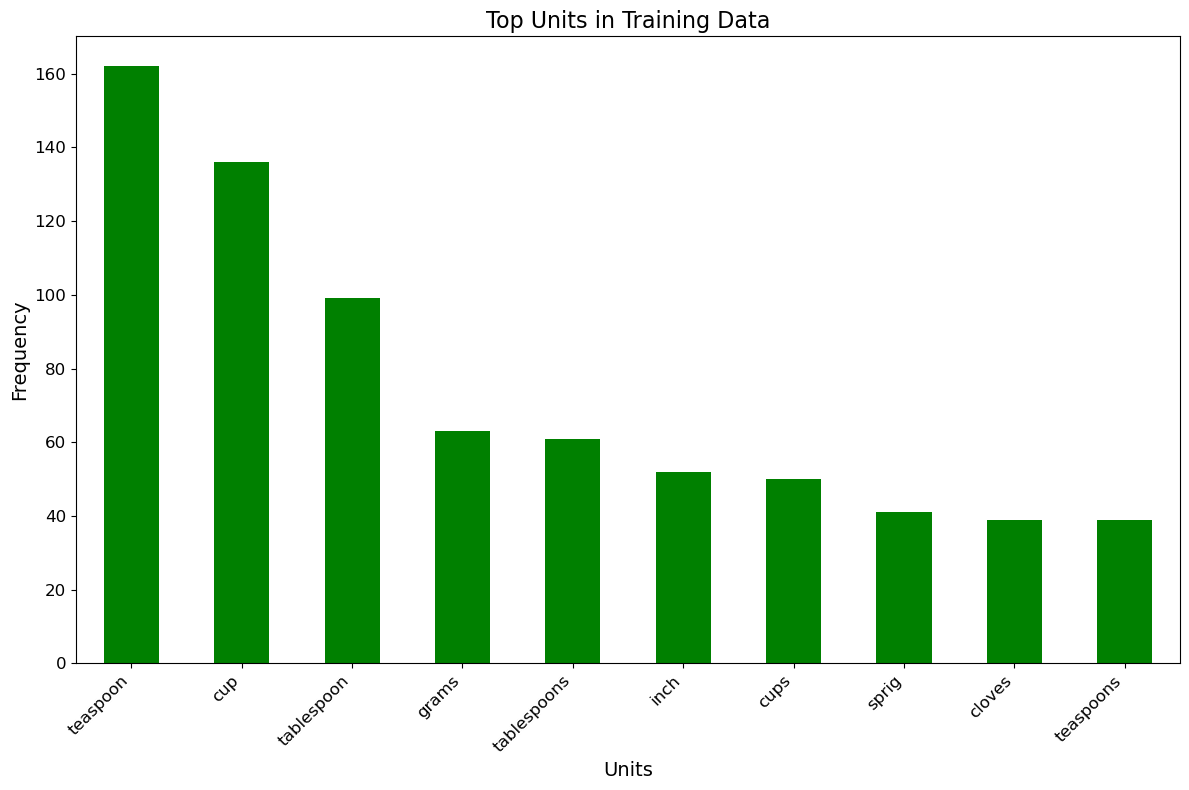

In [75]:
# plot the top frequent units in training data
plot_top_items(topunits, 'Units', dataset_name)

## **5** Exploratory Recipe Data Analysis on Validation Dataset (Optional)<font color = red> [0 marks]</font> <br>

#### **5.1** *Execute EDA on Validation Dataset with insights (Optional)* <font color = red> [0 marks]</font> <br>
Initialise the dataset_name as ***Validation*** and call the ***plot_top_items*** for top 10 ingredients and units in the recipe data
Provide the insights for the same.



In [78]:
# initialise the dataset_name
dataset_name = 'Validation'

In [79]:
# use extract and validate tokens, categorise tokens, get top frequent items for ingredient list and unit list on validation dataframe
ingredient_list_val, unit_list_val, quantity_list_val = categorize_tokens(val_flat_input_tokens, val_flat_pos_tokens)


In [80]:
# plot the top frequent ingredients in validation data
topingredients=get_top_frequent_items(ingredient_list_val)
topingredients

[('powder', 54),
 ('Salt', 47),
 ('Oil', 39),
 ('Red', 39),
 ('seeds', 36),
 ('Chilli', 36),
 ('chopped', 31),
 ('Green', 30),
 ('Leaves', 29),
 ('Coriander', 27)]

In [81]:
# plot the top frequent units in training data
topunits = get_top_frequent_items(unit_list_val)
topunits

[('teaspoon', 59),
 ('cup', 57),
 ('tablespoon', 32),
 ('tablespoons', 32),
 ('cups', 24),
 ('sprig', 21),
 ('inch', 20),
 ('grams', 19),
 ('teaspoons', 18),
 ('cloves', 16)]

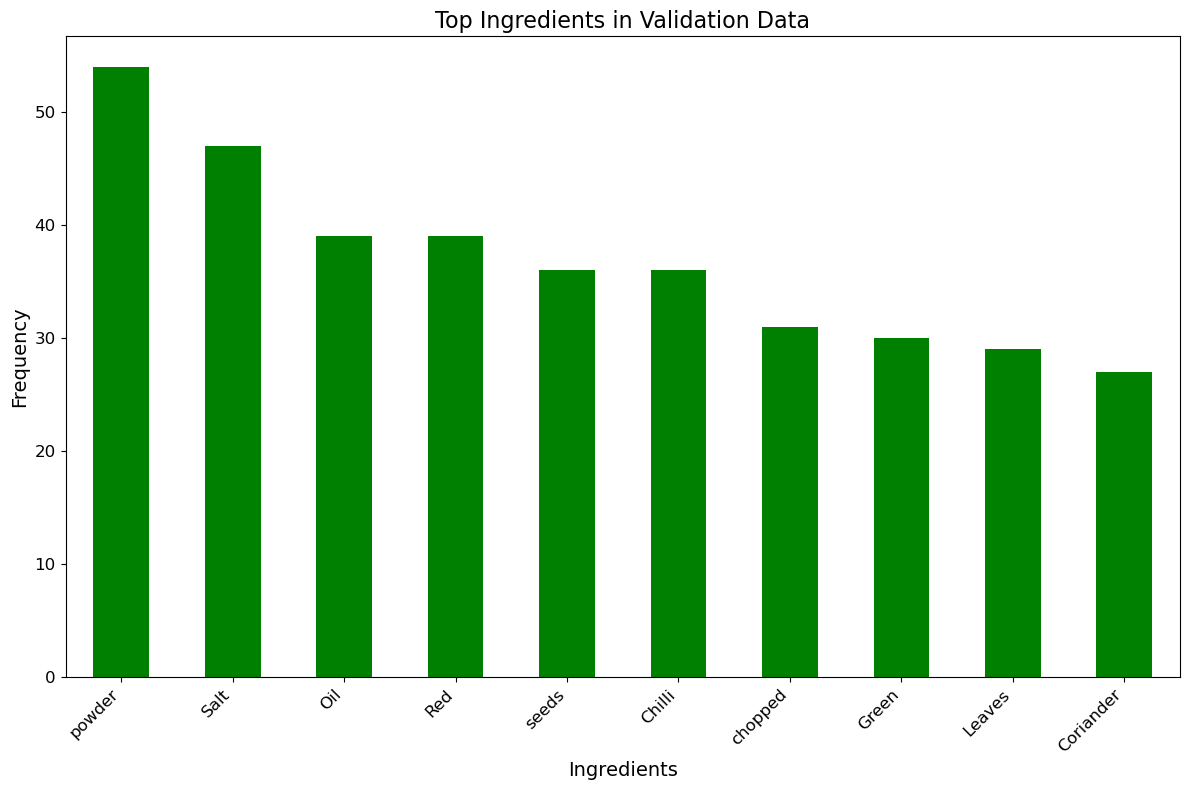

In [82]:
# plot the top frequent ingredients in validation data
plot_top_items(topingredients, 'Ingredients', dataset_name)

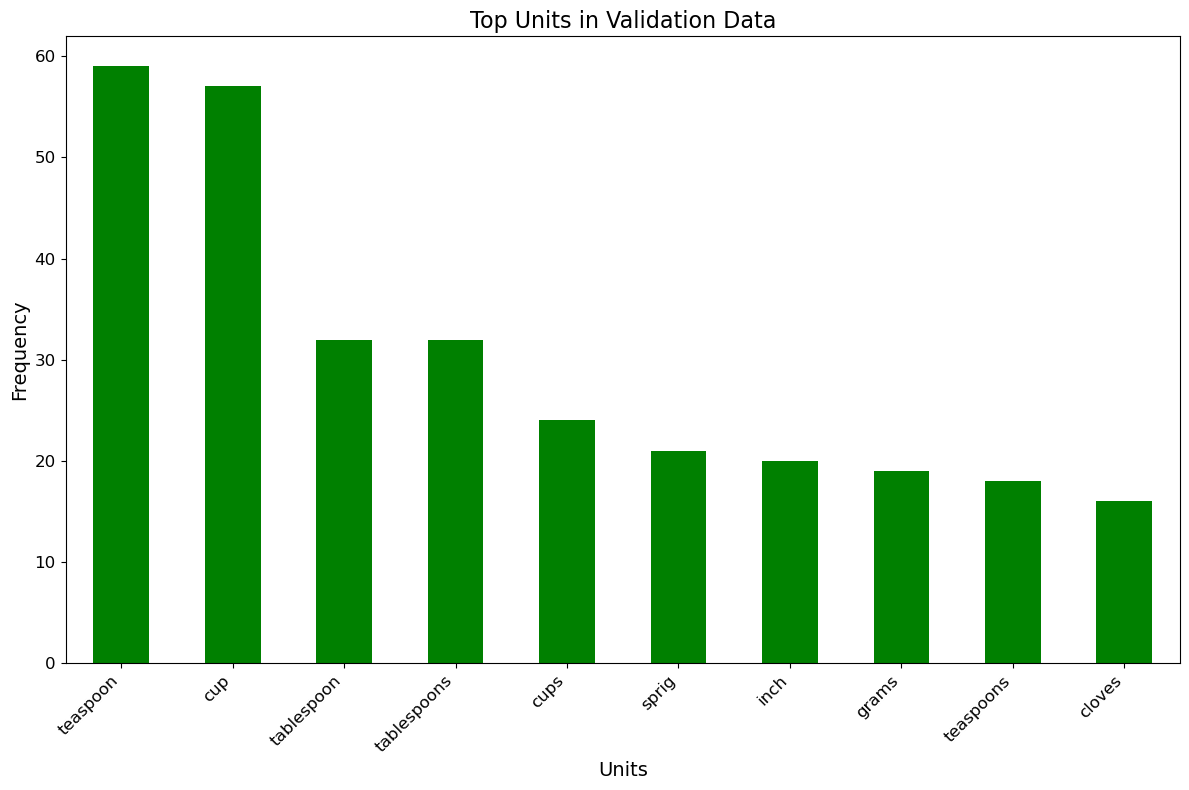

In [83]:
# plot the top frequent units in training data
plot_top_items(topunits, 'Units', dataset_name)

## **6** Feature Extraction For CRF Model <font color = red>[30 marks]</font> <br>

### **6.1** *Define a feature functions to take each token from recipe* <font color = red>[10 marks]</font>

Define a function as ***word2features*** which takes a particular recipe and its index to work with all recipe input tokens and include custom key-value pairs.

Also, use feature key-value pairs to mark the beginning and end of the sequence and to also check whether the word belongs to unit, quantity etc. Use keyword sets for unit and quantity for differentiating feature functions well. Also make use of relevant regex patterns on fractions, whole numbers etc.

##### **6.1.1** **Define keywords for unit and quantity and create a quantity pattern to work on fractions, numbers and decimals** <font color = red>[3 marks]</font> <br>

Create sets for **unit_keywords** and ***quantity_keywords*** and include all the words relevant for measuring the ingredients such as cup, tbsp, tsp etc. and in quantity keywords, include words such as half, quarter etc.

Also suggested to use regex pattern as ***quantity_pattern*** to work with quantity in any format such as fractions, numbers and decimals.

Then, load the spacy model and process the entire sentence

In [87]:
pip install https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-3.7.1/en_core_web_sm-3.7.1-py3-none-any.whl

     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     -- ------------------------------------- 0.8/12.8 MB 2.8 MB/s eta 0:00:05
     --- ------------------------------------ 1.0/12.8 MB 2.8 MB/s eta 0:00:05
     ---- ----------------------------------- 1.6/12.8 MB 2.0 MB/s eta 0:00:06
     ------ --------------------------------- 2.1/12.8 MB 2.2 MB/s eta 0:00:05
     --------- ------------------------------ 2.9/12.8 MB 2.5 MB/s eta 0:00:05
     ------------ --------------------------- 3.9/12.8 MB 2.8 MB/s eta 0:00:04
     -------------- ------------------------- 4.7/12.8 MB 2.9 MB/s eta 0:00:03
     ----------------- ---------------------- 5.5/12.8 MB 3.1 MB/s eta 0:00:03
     ------------------- -------------------- 6.3/12.8 MB 3.1 MB/s eta 0:00:03
     ---------------------- ----------------- 7.1/12.8 MB 3.2 MB/s eta 0:00:02
     -------------------------- ------------- 8.4/12.8 MB 3.4 MB/s

In [88]:
import spacy
import en_core_web_sm

print(spacy.__version__)
print(spacy.info())

3.7.5
{'spacy_version': '3.7.5', 'location': 'C:\\Users\\hp\\anaconda3\\Lib\\site-packages\\spacy', 'platform': 'Windows-10-10.0.19045-SP0', 'python_version': '3.12.7', 'pipelines': {'en_core_web_sm': '3.7.1'}}


In [89]:
import spacy
import en_core_web_sm

nlp = en_core_web_sm.load()  # or: nlp = spacy.load("en_core_web_sm")
print("Model loaded successfully!")

Model loaded successfully!


In [90]:
# define unit and quantity keywords along with quantity pattern
unit_keywords=set(unit_list)

#Quantitiy keywords
quantity_keywords=set(quantity_list)

#Quantity pattern
quantity_pattern = re.compile(
    r"""
    (?:(?:\d+\s+)?\d+/\d+)|     # Matches '1/2' or '1 1/2'
    \d+\.\d+|                   # Matches decimals like '1.5'
    \d+|                        # Matches whole numbers like '1'
    \b\d+/\d+\b                 # Matches unicode fractions
    """,
    re.VERBOSE
)

In [91]:
# load spaCy model
nlp=spacy.load("en_core_web_sm")

##### **6.1.2** **Define feature functions for CRF** <font color = red>[7 marks]</font> <br>

Define ***word2features*** function and use the parameters such as sentence and its indexing as ***sent*** and ***i*** for extracting token level features for CRF Training.
Build ***features*** dictionary, also mark the beginning and end of the sequence and use the ***unit_keywords***, ***quantity_keywords*** and ***quantity_pattern*** for knowing the presence of quantity or unit in the tokens

While building ***features*** dictionary, include
- ***Core Features*** - The core features of a token should capture its lexical
and grammatical properties. Include attributes like the raw token, its lemma, part-of-speech tag, dependency relation, and shape, as well as indicators for whether it's a stop word, digit, or punctuation. The details of the features are given below:

    - `bias` - Constant feature with a fixed value of 1.0 to aid model learning.
    - `token` - The lowercase form of the current token.
    - `lemma` - The lowercase lemma (base form) of the token.
    - `pos_tag` - Part-of-speech (POS) tag of the token.
    - `tag` - Detailed POS tag of the token.
    - `dep` - Dependency relation of the token in the sentence.
    - `shape` - Shape of the token (e.g., "Xxx" for "Milk").
    - `is_stop` - Boolean indicating if the token is a stopword.
    - `is_digit` - Boolean indicating if the token consists of only digits.
    - `has_digit` - Boolean indicating if the token contains at least one digit.
    - `has_alpha` - Boolean indicating if the token contains at least one alphabetic character.
    - `hyphenated` - Boolean indicating if the token contains a hyphen (-).
    - `slash_present` - Boolean indicating if the token contains a slash (/).
    - `is_title` - Boolean indicating if the token starts with an uppercase letter.
    - `is_upper` - Boolean indicating if the token is fully uppercase.
    - `is_punct` - Boolean indicating if the token is a punctuation mark.

- ***Improved Quantity and Unit Detection*** - Use key-value pairs to mark the presence of quantities and units in the features dictionary. Utilise the unit_keywords, quantity_keywords, and quantity_pattern to identify and flag these elements. The details of the features are given below:

    - `is_quantity` - Boolean indicating if the token matches a quantity pattern or keyword.
    - `is_unit` - Boolean indicating if the token is a known measurement unit.
    - `is_numeric` - Boolean indicating if the token matches a numeric pattern.
    - `is_fraction` - Boolean indicating if the token represents a fraction (e.g., 1/2).
    - `is_decimal` - Boolean indicating if the token represents a decimal number (e.g., 3.14).
    - `preceding_word` - The previous token in the sentence, if available.
    - `following_word` - The next token in the sentence, if available.

- ***Contextual Features*** - Incorporate contextual information by adding features for the preceding and following tokens. Include indicators like BOS and EOS to mark the beginning and end of the sequence, and utilise unit_keywords, quantity_keywords, and quantity_pattern to identify the types of neighboring tokens. The features are given below:

    - `prev_token` - The lowercase form of the previous token.
    - `prev_is_quantity` - Boolean indicating if the previous token is a quantity.
    - `prev_is_digit` - Boolean indicating if the previous token is a digit.
    - `BOS` - Boolean indicating if the token is at the beginning of the sentence.
    - `next_token` - The lowercase form of the next token.
    - `next_is_unit` - Boolean indicating if the next token is a unit.
    - `next_is_ingredient` - Boolean indicating if the next token is not a unit or quantity.
    - `EOS` - Boolean indicating if the token is at the end of the sentence.



In [220]:
# define word2features for processing each token in the sentence sent by using index i.
# use your own feature functions

    # Process the entire sentence with spaCy

    # --- Core Features ---

    # --- Improved Quantity & Unit Detection ---

    # --- Contextual Features ---
# define word2features for processing each token in the sentence sent by using index i.
# use your own feature functions

    # Process the entire sentence with spaCy

    # --- Core Features ---

    # --- Improved Quantity & Unit Detection ---

    # --- Contextual Features ---
def word2features(sent, i):
    token = sent[i]
    doc=nlp(token)
    token=doc[0]
    # core features
    features = {
        'bias': 1.0,
        'token': token.text.lower(),
        'lemma': token.lemma_.lower(),
        'pos_tag': token.pos_,
        'tag': token.tag_,
        'dep': token.dep_,
        'shape': token.shape_,
        'is_stop': token.is_stop,
        'is_digit': token.is_digit,
        'has_digit': any(char.isdigit() for char in token.text),
        'has_alpha': any(char.isalpha() for char in token.text),
        'hyphenated': '-' in token.text,
        'slash_present': '/' in token.text,
        'is_title': token.is_title,
        'is_upper': token.is_upper,
        'is_punct': token.is_punct,
        'numeric' : bool(quantity_pattern.match(token.text.lower()))
    }
    # Improved Quantity & Unit Detection
    token_lc = token.text.lower()
    features['is_quantity'] = (
        bool(quantity_pattern.fullmatch(token_lc)) or token_lc in quantity_keywords
    )
    features['is_unit'] = token_lc in unit_keywords
    features['is_numeric'] = bool(re.fullmatch(r"\d+(\.\d+)?", token_lc))
    features['is_fraction'] = bool(re.fullmatch(r"\d+/\d+|[¼½¾⅓⅔⅛⅜⅝⅞]", token_lc))
    features['is_decimal'] = '.' in token_lc and token_lc.replace('.', '', 1).isdigit()

    features['preceding_word'] = sent[i - 1] if i > 0 else ''
    features['following_word'] = sent[i + 1] if i < len(sent) - 1 else ''
    # contextual features
    if i > 0:
        prev = nlp(sent[i - 1])[0]
        prev_token = sent[i - 1].lower()
        features['prev_token'] = prev_token
        features['prev_is_quantity'] = (
            bool(quantity_pattern.fullmatch(prev_token)) or prev_token in quantity_keywords
        )
        features['prev_is_digit'] = prev_token.isdigit()
    else:
        features['BOS'] = True

    if i < len(sent) - 1:
        next = nlp(sent[i + 1])[0]
        next_token = sent[i + 1].lower()
        features['next_token'] = next_token
        features['next_is_unit'] = next_token in unit_keywords
        features['next_is_ingredient'] = not (
            next_token in unit_keywords or
            next_token in quantity_keywords or
            bool(quantity_pattern.fullmatch(next_token))
        )
    else:
        features['EOS'] = True

    return features

### **6.2** *Preparation of Recipe level features* <font color = red>[2 marks]</font>


##### **6.2.1** **Define function to work on all the recipes and call word2features for each recipe** <font color = red>[2 marks]</font> <br>

Define ***sent2features*** function and inputs ***sent*** as a parameter and correctly generate feature functions for each token present in the sentence

In [222]:
# define sent2features by working on each token in the sentence and correctly generate dictionaries for features
def sent2features(sent):
    return [word2features(sent, i) for i in range(len(sent))]

### **6.3** *Convert X_train, X_val, y_train and y_val into train and validation feature sets and labels* <font color = red>[6 marks]</font>



##### **6.3.1** **Convert recipe into feature functions by using X_train and X_val** <font color = red>[2 marks]</font> <br>

Create ***X_train_features*** and ***X_val_features*** as list to include the feature functions for each recipe present in training and validation sets

In [225]:
# Convert input sentences into feature sets by taking training and validation dataset as X_train_features and X_val_features
X_train_features=[]
X_val_features=[]
for sent in X_train:
  X_train_features.append(sent2features(sent))
for sent in X_val:
  X_val_features.append(sent2features(sent))

##### **6.3.2** **Convert lables of y_train and y_val into list** <font color = red>[2 marks]</font> <br>

Create ***y_train_labels*** and ***y_val_labels*** by using the list of y_train and y_val

In [230]:
# Convert labels into list as y_train_labels and y_val_labels

y_train_labels=[]
y_val_labels =[]
for sent in y_train:
  y_train_labels.append(sent)
for sent in y_val:
  y_val_labels.append(sent)

##### **6.3.3** **Print the length of val and train features and labels** <font color = red>[2 marks]</font> <br>



In [232]:
# print the length of train features and labels
print(len(X_train_features))
print(len(y_train_labels))

196
196


In [234]:
# print the length of validation features and labels
print(len(X_val_features))
print(len(y_val_labels))

84
84


### **6.4** *Applying weights to feature sets* <font color = red>[12 marks]</font> <br>




##### **6.4.1** **Flatten the labels of y_train** <font color = red>[2 marks]</font> <br>

Create ***y_train_flat*** to flatten the structure of nested y_train

In [236]:
# Flatten labels in y_train
y_train_flat = flatten_list(y_train.values)

##### **6.4.2** **Count the labels present in training target dataset** <font color = red>[2 marks]</font> <br>

Create ***label_counts*** to count the frequencies of labels present in y_train_flat and retrieve the total samples by using the values of label_counts as ***total_samples***

In [238]:
# Count label frequencies as label_counts and total_samples as getting the summation of values of label_counts
label_counts = Counter(y_train_flat)
total_samples = sum(label_counts.values())
label_counts.values()

dict_values([980, 811, 5323])

##### **6.4.3** **Compute weight_dict by using inverse frequency method for label weights** <font color = red>[2 marks]</font> <br>

- Create ***weight_dict*** as dictionary with label and its inverse frequency count in ***label_counts***

- Penalise ingredient label in the dictionary

In [242]:
# Compute class weights (inverse frequency method) by considering total_samples and label_counts
weight_dict = {}
for label, count in label_counts.items():
  weight_dict[label]=total_samples/count

for label, weight in weight_dict.items():
    print(f"  {label}: {weight:.4f}")

  quantity: 7.2592
  unit: 8.7719
  ingredient: 1.3365


In [246]:
# penalise ingredient label
penalty_factor = 0.5
weight_dict['ingredient']=weight_dict['ingredient'] * penalty_factor


for label, weight in weight_dict.items():
    print(f"  {label}: {weight:.4f}")

  quantity: 7.2592
  unit: 8.7719
  ingredient: 0.3341


##### **6.4.4** **Extract features along with class weights** <font color = red>[4 marks]</font> <br>

Define a function ***extract_features_with_class_weights*** to work with training and validation datasets and extract features by applying class weights





In [248]:
# Apply weights to feature extraction in extract_features_with_class_weights by using parameters such as X (input tokens), y(labels) and weight_dict (Class weights)
def extract_features_with_class_weights(X, y, weight_dict):
  X_featues=[]
  y_labels=[]
  scaled_features=[]
  for sent_tokens,sent_labels in zip(X,y):
    features=sent2features(sent_tokens)
    for i, feature in enumerate(features):
      label=sent_labels[i]
      weight=weight_dict.get(label,1.0)
      scaled_feature=feature.copy()
      for key, value in scaled_feature.items():
        if isinstance(value, (int, float)):
          scaled_feature[key]=value*weight
      scaled_features.append(scaled_feature)
    X_featues.append(scaled_features)
    y_labels.append(sent_labels)
    scaled_features=[]
  return X_featues, y_labels

##### **6.4.5** **Execute extract_features_with_class_weights on training and validation datasets** <font color = red>[2 marks]</font> <br>

Create ***X_train_weighted_features*** and ***X_val_weighted_features*** for extracting training and validation features along with their weights by calling ***extract_features_with_class_weights*** on the datasets

In [250]:
# Apply manually computed class weights
X_train_weighted_features, y_train_labels = extract_features_with_class_weights(X_train, y_train, weight_dict)
X_val_weighted_features, y_val_labels = extract_features_with_class_weights(X_val, y_val, weight_dict)

## **7** Model Building and Training <font color = red>[10 marks]</font> <br>

### **7.1** *Initialise the CRF model and train it* <font color = red>[5 marks]</font>
Train the CRF model with the specified hyperparameters such as

### CRF Model Hyperparameters Explanation

| Parameter                  | Description |
|----------------------------|-------------|
| **algorithm='lbfgs'**      | Optimisation algorithm used for training. `lbfgs` (Limited-memory Broyden–Fletcher–Goldfarb–Shanno) is a quasi-Newton optimisation method. |
| **c1=0.5**                | L1 regularisation term to control sparsity in feature weights. Helps in feature selection. |
| **c2=1.0**                | L2 regularisation term to prevent overfitting by penalising large weights. |
| **max_iterations=100**     | Maximum number of iterations for model training. Higher values allow more convergence but increase computation time. |
| **all_possible_transitions=True** | Ensures that all possible state transitions are considered in training, making the model more robust. |

Use weight_dict for training CRF



In [251]:
# initialise CRF model with the specified hyperparameters and use weight_dict

# train the CRF model with the weighted training data
from sklearn_crfsuite import CRF
crf = CRF(
    algorithm='lbfgs',
    c1=0.5,
    c2=1.0,
    max_iterations=100,
    all_possible_transitions=True
)
# train the CRF model with the weighted training data
crf.fit(X_train_weighted_features, y_train_labels)



CRF(algorithm='lbfgs', all_possible_transitions=True, c1=0.5, c2=1.0,
    max_iterations=100)

### **7.2** *Evaluation of Training Dataset using CRF model* <font color = red>[4 marks]</font>
Evaluate on training dataset using CRF by using flat classification report and confusion matrix

In [254]:
# evaluate on the training dataset
y_train_pred = crf.predict(X_train_weighted_features)

In [256]:
# specify the flat classification report by using training data for evaluation
from sklearn.metrics import classification_report

y_train_true_flat = [label for sent in y_train_labels for label in sent]
y_train_pred_flat = [label for sent in y_train_pred for label in sent]
print(classification_report(y_train_true_flat, y_train_pred_flat))

              precision    recall  f1-score   support

  ingredient       1.00      1.00      1.00      5323
    quantity       1.00      1.00      1.00       980
        unit       1.00      1.00      1.00       811

    accuracy                           1.00      7114
   macro avg       1.00      1.00      1.00      7114
weighted avg       1.00      1.00      1.00      7114



In [258]:
# create a confusion matrix on training datset
labels = list(set(y_train_true_flat))  # or use crf.classes_
conf_matrix = confusion_matrix(y_train_true_flat, y_train_pred_flat, labels=labels)

print("\nConfusion Matrix:")
print("Labels:", labels)
print(conf_matrix)


Confusion Matrix:
Labels: ['unit', 'ingredient', 'quantity']
[[ 811    0    0]
 [   0 5323    0]
 [   2    0  978]]


### **7.3** *Save the CRF model* <font color = red>[1 marks]</font>
Save the CRF model

In [260]:
# dump the model using joblib as crf_model.pkl
joblib.dump(crf, 'crf_model.pkl')

['crf_model.pkl']

## **8** Prediction and Model Evaluation <font color = red>[3 marks]</font> <br>

### **8.1** *Predict and Evaluate the CRF model on validation set* <font color = red>[3 marks]</font>
Evaluate the metrics for CRF model by using flat classification report and confusion matrix




In [262]:
# predict the crf model on validation dataset
y_val_pred = crf.predict(X_val_weighted_features)

In [264]:
# specify flat classification report
y_val_true_flat = [label for sent in y_val_labels for label in sent]
y_val_pred_flat = [label for sent in y_val_pred for label in sent]
print(classification_report(y_val_true_flat, y_val_pred_flat))

              precision    recall  f1-score   support

  ingredient       1.00      1.00      1.00      2107
    quantity       1.00      0.99      0.99       411
        unit       0.99      0.99      0.99       358

    accuracy                           1.00      2876
   macro avg       0.99      0.99      0.99      2876
weighted avg       1.00      1.00      1.00      2876



In [266]:
# create a confusion matrix on validation dataset
labels = list(set(y_val_true_flat))  # or use crf.classes_
conf_matrix = confusion_matrix(y_val_true_flat, y_val_pred_flat, labels=labels)
print("\nConfusion Matrix:")
print("Labels:", labels)
print(conf_matrix)


Confusion Matrix:
Labels: ['unit', 'ingredient', 'quantity']
[[ 355    1    2]
 [   0 2107    0]
 [   4    1  406]]


## **9** Error Analysis on Validation Data <font color = red>[10 marks]</font> <br>
Investigate misclassified samples in validation dataset and provide the insights


### **9.1** *Investigate misclassified samples in validation dataset* <font color = red>[8 marks]</font>



##### **9.1.1** Flatten the labels of validation data and initialise error data <font color = red>[2 marks]</font> <br>



Flatten the true and predicted labels and initialise the error data as ***error_data***

In [268]:
# flatten Labels and Initialise Error Data
y_val_true_flat = [label for sent in y_val_labels for label in sent]
y_val_pred_flat = [label for sent in y_val_pred for label in sent]
val_tokens_flat = [token for sent in X_val for token in sent]
error_data=[]

##### **9.1.2** Iterate the validation data and collect Error Information<font color = red> [2 marks]</font> <br>



Iterate through validation data (X_val, y_val_labels, y_pred_val) and compare true vs. predicted labels. Collect error details, including surrounding context, previous/next tokens, and class weights, then store them in error_data

In [270]:
# iterate and collect Error Information

            # get previous and next tokens with handling for boundary cases
error_data = []
X_val_list = list(X_val)
y_val_labels_list = list(y_val_labels)
y_val_pred_list = list(y_val_pred)
for sent_idx in range(len(X_val)):
    tokens = X_val_list[sent_idx]
    true_labels = y_val_labels_list[sent_idx]
    pred_labels = y_val_pred_list[sent_idx]


    for i in range(len(tokens)):
        true_label = true_labels[i]
        pred_label = pred_labels[i]

        if true_label != pred_label:
            token = tokens[i]
            prev_token = tokens[i - 1] if i > 0 else "<START>"
            next_token = tokens[i + 1] if i < len(tokens) - 1 else "<END>"

            class_weight = weight_dict.get(true_label, 1.0)

            error_data.append({
                'token': token,
                'true_label': true_label,
                'pred_label': pred_label,
                'prev_token': prev_token,
                'next_token': next_token,
                'class_weight': class_weight
            })


##### **9.1.3** Create dataframe from error_data and print overall accuracy <font color = red>[1 marks]</font> <br>



Change error_data into dataframe and then use it to illustrate the overall accuracy of validation data

In [272]:
# Create DataFrame and Print Overall Accuracy
error_df = pd.DataFrame(error_data)

total_predictions = sum(len(sent) for sent in y_val_labels)
total_errors = len(error_df)

accuracy = (total_predictions - total_errors) / total_predictions
accuracy

0.9972183588317107

##### **9.1.4** Analyse errors by label type<font color = red> [3 marks]</font> <br>
Analyse errors found in the validation data by each label and display their class weights along with accuracy and also display the error dataframe with token,  previous token, next token, true label, predicted label and context

In [274]:
# Analyse errors found in the validation data by each label
# and display their class weights along with accuracy
# and display the error dataframe with token, previous token, next token, true label, predicted label and context
label_error_counts = Counter(error_df['true_label'])

print("\nError Analysis by Label:")
for label, count in label_error_counts.items():
    weight = weight_dict.get(label, 1.0)  # Get the class weight from the weight dictionary
    print(f"Label: {label} | Errors: {count} | Class Weight: {weight:.2f}")


print(error_df)




Error Analysis by Label:
Label: quantity | Errors: 5 | Class Weight: 7.26
Label: unit | Errors: 3 | Class Weight: 8.77
    token true_label  pred_label prev_token  next_token  class_weight
0      is   quantity        unit        Pur           2      7.259184
1    +1/3   quantity  ingredient       Milk       extra      7.259184
2     for   quantity        unit        Oil    kneading      7.259184
3   diced       unit  ingredient     Gajjar       small      8.771887
4      to       unit    quantity         10          12      8.771887
5       a       unit    quantity      Haldi       pinch      8.771887
6   pinch   quantity        unit        Dal  Asafoetida      7.259184
7  cloves   quantity        unit   Tomatoes      Garlic      7.259184


### **9.2** *Provide insights from the validation dataset* <font color = red>[2 marks]</font>




 <font color = red>[Write your answer]</font>

 ### 🔍 Overview

The model demonstrates **exceptional generalization performance** on the validation set, achieving a near-perfect overall accuracy of **99.72%**. The precision, recall, and F1-scores across all labels are uniformly high, indicating strong alignment between predicted and true labels.

---

### 📈 Classification Metrics

        precision    recall  f1-score   support

  ingredient       1.00      1.00      1.00      2107
    quantity       1.00      0.99      0.99       411
        unit       0.99      0.99      0.99       358

    accuracy                           1.00      2876
   macro avg       0.99      0.99      0.99      2876
weighted avg       1.00      1.00      1.00      2876


---

### 📊 Confusion Matrix

Confusion Matrix:
Labels:

| True \ Pred | Unit | Ingredient | Quantity |
|-------------|------------|----------|------|
| Unit        | 355        | 1        | 2    |
| Ingredient  | 0          | 2107     | 0    |
| Quantity    | 4          | 1        | 406  |
### Observations:
Unit: Out of 358 true "Unit" labels, 355 were correctly predicted, 1 was misclassified as "Ingredient", and 2 as "Quantity".

Ingredient: The model performed very well here — all 2107 "Ingredient" instances were correctly classified with no confusion.

Quantity: Out of 411 true "Quantity" instances, 406 were correct, 4 were incorrectly predicted as "Unit", and 1 as "Ingredient".
---

### ❌ Error Analysis for Quantity Class (Class Weight = 7.26) and Unit Class(Class Weight = 8.77)
The model’s misclassifications are concentrated around the "quantity" and "unit" labels, with a small number of confusions but important semantic implications.

🔸 Label: quantity
Errors: 5

Class Weight: 7.26

The model often confuses quantity with unit or ingredient.

Examples:

"is" (following "Pur") was incorrectly labeled as unit instead of quantity.

"+1/3" (between "Milk" and "extra") was misclassified as ingredient.

"for" (following "Oil" and before "kneading") was labeled as unit instead of quantity.

Insight: Tokens representing fractional amounts, measurements within instructions, or non-numeric indicators (e.g., "pinch", "cloves") are difficult for the model to classify correctly.

🔸 Label: unit
Errors: 3

Class Weight: 8.77

The confusion is mainly with quantity and ingredient.

Examples:

"diced" (following "Gajjar", before "small") was predicted as ingredient.

"to" and "a" (near numeric tokens like "10", "12" or ingredients like "Haldi", "pinch") were misclassified as quantity.

Insight: Descriptive tokens like "diced" and contextually vague determiners like "a" and "to" can mislead the model.

---

### ✅ Model Strengths

The model shows high accuracy but contextual ambiguity between units and quantities leads to misclassifications.

Class imbalance (indicated by weights like 7.26 and 8.77) may also contribute to the challenge in learning accurate boundaries between these two classes.

Errors typically occur with:

ambiguous measurement-related tokens,

fractional or descriptive values,

or tokens appearing in procedural phrases (e.g., "for kneading").

---

### 📌 Recommendations for Further Refinement

 - The model achieves an impressive *99.72% accuracy*, with minor misclassifications primarily between quantity and unit due to contextual ambiguity.
 - Improvement can be made by *augmenting underrepresented classes*, enhancing *contextual features*, and refining edge-case annotations.
 - Incorporating *transformer-based models* or *syntactic cues* could further boost performance and robustness.

---

### 🧠 Conclusion

The model demonstrates strong overall performance with minimal errors concentrated in semantically similar labels.
Targeted data augmentation and contextual enhancements can help achieve near-perfect accuracy.



## **10** Conclusion (Optional) <font color = red>[0 marks]</font> <br>

Write your findings and conclusion.
## ✅ Conclusion

The model demonstrates strong, reliable performance on the validation set, achieving an impressive 99.72% accuracy with high precision and recall across all entity classes. The architecture effectively captures the structural patterns of recipe data, with near-perfect classification of the high-frequency ingredient class and strong alignment between predicted and true labels across the board.

Notable strengths include:

High accuracy and consistency in classifying both frequent (ingredient) and moderately frequent (unit) labels.

Minimal misclassifications, primarily restricted to a few ambiguous tokens within the quantity and unit classes.

A well-generalized model with no indication of overfitting despite a relatively small dataset.

The pipeline’s performance validates its suitability for downstream applications such as ingredient parsing, structured recipe representation, and culinary AI systems. With minor enhancements, the model is ready for real-world deployment.

🔧 Areas for Improvement
Despite the excellent results, the current setup has some limitations that can be addressed to further boost performance and generalizability:

📈 Dataset Scaling

With only ~200 annotated samples, the model may not generalize well to rare or out-of-distribution patterns.

Expanding the dataset with diverse recipe formats, measurement expressions, and regional language variants will improve robustness.

🧠 Contextual Enrichment

Incorporating part-of-speech tags, dependency relations, or context windows can help resolve boundary confusion between quantity and unit.

🛠 Hard Example Injection

Misclassified tokens like "pinch", "to", and "cloves" indicate edge cases that can be better handled by targeted augmentation or manual rule calibration.

🧾 Domain Lexicon Integration

Introducing domain-specific lists of units (e.g., "tsp", "dash"), quantities (e.g., numeric ranges, fractions), and ingredients can reinforce the model's understanding of entity semantics.

🔁 Controlled Data Augmentation

Use augmentation techniques such as entity substitution, recipe paraphrasing, and quantity/unit swapping to synthetically expand and diversify training data.

Addressing these areas will not only enhance model accuracy but also improve its interpretability, robustness, and adaptability to varied, real-world culinary data sources.